## Problem Set 12

First the exercises:
* Let $\mu=\frac{1}{|S|}\sum_{x_i\in S} x_i$ let us expand 
\begin{align*}
\sum_{x_i\in S} ||x_i-\mu||^2 &=\sum_{x_i\in S}(x_i-\mu)^T(x_i-\mu)\\
    &= |S|\mu^T\mu+\sum_{x_i\in S}\left( x_i^Tx_i-2\mu^T x_i \right) \\
    &= \frac{1}{|S|}\left(\sum_{(x_i,x_j)\in S\times S} x_i^T x_j\right) + \sum_{x_i\in S} \left( x_i^Tx_i-\frac{2}{|S|}\left(\sum_{x_j\in S} x_j^T x_i\right)\right)\\
      &= \sum_{x_i\in S} x_i^Tx_i-\frac{1}{|S|}\sum_{(x_i,x_j)\in S\times S} x_j^T x_i\\
      &= \frac{1}{2}\left(\sum_{x_i\in S} x_i^Tx_i-\frac{2}{|S|}\sum_{(x_i,x_j)\in S\times S} x_j^T x_i+\sum_{x_j\in S} x_j^Tx_j \right)\\
      &= \frac{1}{2|S|}\left(\sum_{(x_i,x_j)\in S\times S} x_i^Tx_i-2\sum_{(x_i,x_j)\in S\times S} x_j^T x_i+\sum_{(x_i,x_j)\in S\times S} x_j^Tx_j \right)\\
      &= \frac{1}{2|S|}\sum_{(x_i,x_j)\in S\times S} (x_i-x_j)^T(x_i-x_j)\\
      &= \frac{1}{2|S|}\sum_{(x_i,x_j)\in S\times S} ||x_i-x_j||^2
\end{align*}
as desired.
* So the $K$-means algorithm consists of iterations of two steps, we will show that either the algorithm has stabilized or that each of these steps decreases
\[ T=\sum_{c=1}^K \sum_{x_i\in S_c}||x_i-\mu_c||^2,\] where $S_c$ is the $c$th cluster and $\mu_c$ is the previously defined mean over that cluster. The sequence defined by these sums is therefore monotonically decreasing and bounded below so it will eventually approach the maximal lower bound. 

The value of $\mu$ that minimizes $\sum_{x_i\in S_c}||x_i-\mu||^2$ is $\frac{1}{|S_c|}\sum_{x_i\in S_c} x_i$ (we can check this by setting the derivative with respect to $\mu$ to zero). So updating the mean estimates will never increase $T$. If we do not update the mean estimates than the cluster assignments will not change on the next step. 

The next step maps samples to their closest mean which can only decrease the sum $T$.

### Python Lab

Now let us load our standard libraries.

In [1]:
import numpy as np
import pandas as pd
import keras
from keras.datasets import mnist

Using TensorFlow backend.


Let us load up a sample dataset.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
x_train.shape

(60000, 28, 28)

In [4]:
import matplotlib.pyplot as plt

In [5]:
%matplotlib inline

Label is 7.


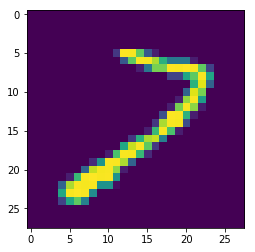

In [6]:
randix = np.random.randint(0,60000)
plt.imshow(x_train[randix])
print("Label is {}.".format(y_train[randix]))

In [7]:
x_train_f = x_train.reshape(60000,-1)

In [8]:
x_train_f.shape

(60000, 784)

In [9]:
x_test_f = x_test.reshape(-1, 28**2)

In [10]:
x_test_f.shape

(10000, 784)

In [11]:
from sklearn.preprocessing import OneHotEncoder as OHE

In [12]:
ohe = OHE(sparse = False)
y_train_ohe = ohe.fit_transform(y_train.reshape(-1,1))
y_test_ohe = ohe.fit_transform(y_test.reshape(-1,1))

In [13]:
np.argmax(y_train_ohe[randix]) == y_train[randix]

True

Now construct a KNN classifier

In [14]:
from scipy.spatial.distance import cdist
from sklearn.neighbors import KDTree
class KNNClassifier(object):

    def fit(self,x,y,k=1,fun=lambda x: np.mean(x,axis=0)):
        """Fits a KNN regressor.
        Args:
            x (numpy array) Array of samples indexed along first axis.
            y (numpy array) Array of corresponding labels.
            k (int) the number of neighbors
            fun (function numpy array --> desired output) Function to be applied to k-nearest
              neighbors for predictions
        """
        self.x = x[:]
        self.y = y[:]
        self.k = k
        self.f = fun
        self.tree = KDTree(self.x)
        
    def predict_one(self, sample):
        """
        Run prediction on sample
        
        Args:
            new_x (numpy array) sample
        
        """
        dists = cdist(sample.reshape(1,-1),self.x)
        ix = np.argpartition(dists,self.k-1)[0,0:self.k]
        return self.f(self.y[ix])
    
    def predict(self, samples):
        """
        Run predictions on list.
        Args:
            samples (numpy array) samples
        """
        return np.array([self.predict_one(x) for x in samples])
    
    def faster_predict(self,samples):
        """
        Run faster predictions on list.
        Args:
            samples (numpy array) samples
        """
        _, ixs = self.tree.query(samples, k=self.k)
        #print(ixs)
        return np.array([self.f(self.y[ix]) for ix in ixs])
        


In [15]:
classifier = KNNClassifier()

In [16]:
classifier.fit(x_train_f, y_train_ohe, k=1)

In [ ]:
preds=classifier.predict(x_test_f[:500])

Calculate accuracy on this very small subset.

In [ ]:
np.mean(np.argmax(preds,axis=1)==y_test[:500])

In [ ]:
faster_preds = classifier.faster_predict(x_test_f[:500])

In [ ]:
np.mean(np.argmax(faster_preds,axis=1)==y_test[:500])

Okay now, let us try the clustering algorithm.

In [21]:
def cluster_means(x,cluster_assignments,k):
    """
    Return the new cluster means given the cluster assignments
    """
    cluster_counter = np.zeros((k,1))
    cluster_means = np.zeros((k, x.shape[1]))
    for cluster, pt in zip(cluster_assignments, x):
        #print(x)
        cluster_means[cluster] += pt
        cluster_counter[cluster]+=1
    z = cluster_means/cluster_counter
    #print(z)
    return z

class KMeansCluster(object):

    
    #Fit a clustering object on a dataset x consisting of samples on each row
    #by the K-means algorithm into k clusters
    def fit(self,x,k):
        """
        Fit k-means clusterer
        
        Args:
            x (numpy array) samples
            k (int) number of clusters
        """
        num_samples, num_features = x.shape[0], x.shape[1]
        #Randomly assign clusters
        cluster_assignments = np.random.randint(0,k,num_samples)
        
        #initialize
        cluster_mus = np.zeros((k,num_features))
        
        #update
        new_cluster_mus = cluster_means(x,cluster_assignments,k)
        count = 1
        while (cluster_mus!=new_cluster_mus).any() and count < 10**3:
            count += 1
            print("Iteration {}".format(count),end="\r")
            cluster_mus = new_cluster_mus
            #calculate distances
            distances = cdist(x,cluster_mus, metric = 'sqeuclidean')
            np.argmin(distances, axis = 1, out = cluster_assignments)
            new_cluster_mus = cluster_means(x,cluster_assignments,k)
        self.cluster_means = cluster_means
        self.cluster_assignments = cluster_assignments
        self.x = x[:]
           


In [22]:
clusterer = KMeansCluster()
clusterer.fit(x_train_f,10)

In [23]:
from sklearn.metrics import confusion_matrix

In [24]:
confusion_matrix(y_train, clusterer.cluster_assignments)

array([[   2,    7,  167,  223, 1144,   44, 4248,   80,    3,    5],
       [3046,    9,    6,    5,    6,    6,    0,    8, 3646,   10],
       [ 327, 4153,  133,  257,  222,  193,   43,  178,  387,   65],
       [  50,  158,   33, 3868,  464,  168,   22,  914,  419,   35],
       [ 206,   33,  142,    0,  185, 3201,    7,   11,  168, 1889],
       [ 228,    5,   72, 1811, 1586,  372,   51,  960,  172,  164],
       [  45,   65, 3985,   33, 1407,   65,   54,   23,  240,    1],
       [ 257,   40,    4,    5,   11, 1805,   20,   17,  340, 3766],
       [ 267,   43,   45, 1009,  305,  179,   29, 3486,  326,  162],
       [  86,   16,    9,   83,   28, 2913,   39,   72,  260, 2443]])

In [27]:
cluster_samples = clusterer.x[clusterer.cluster_assignments == 0]

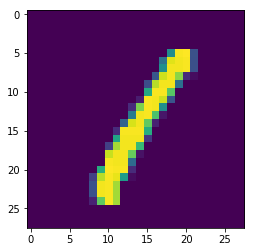

In [28]:
plt.imshow(cluster_samples[0].reshape(28,28))

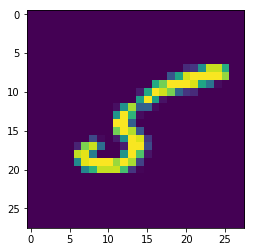

In [29]:
plt.imshow(cluster_samples[1].reshape(28,28))

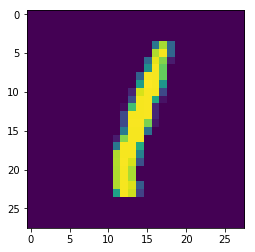

In [30]:
plt.imshow(cluster_samples[23].reshape(28,28))

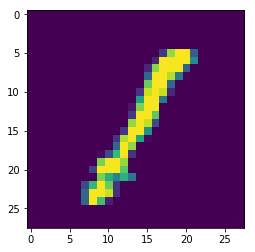

In [ ]:
plt.imshow(cluster_samples[50].reshape(28,28))

In [ ]:
np.mean(classifier.faster_predict(cluster_samples),axis=0)

Let us load the credit card dataset and extract a small dataframe of numerical features to test on.

In [ ]:
big_df = pd.read_csv("UCI_Credit_Card.csv")

In [ ]:
big_df.head()

In [ ]:
len(big_df)

In [ ]:
len(big_df.dropna())

In [ ]:
df = big_df.drop(labels = ['ID'], axis = 1)

In [ ]:
labels = df['default.payment.next.month']
df.drop('default.payment.next.month', axis = 1, inplace = True)

In [ ]:
num_samples = 25000

In [ ]:
train_x, train_y = df[0:num_samples], labels[0:num_samples]

In [ ]:
test_x, test_y = df[num_samples:], labels[num_samples:]

In [ ]:
test_x.head()

In [ ]:
train_y.head()

Now let us write our transformation function.

In [ ]:
class bin_transformer(object):
    
    def __init__(self, df, num_quantiles = 2):
        self.quantiles = df.quantile(np.linspace(1./num_quantiles, 1.-1./num_quantiles,num_quantiles-1))
            
    
    def transform(self, df):
        new = pd.DataFrame()
        fns = {}
        for col_name in df.axes[1]:
            for ix, q in self.quantiles.iterrows():
                quart = q[col_name]
                new[col_name+str(ix)] = (df[col_name] >= quart)
                fns[col_name+str(ix)] =(col_name, lambda x: x[col_name]>=quart)
        return new, fns

In [ ]:
transformer = bin_transformer(df,5)

In [ ]:
train_x_t, tr_fns = transformer.transform(train_x)

In [ ]:
test_x_t, test_fns = transformer.transform(test_x)

In [ ]:
train_x_t.head()

In [ ]:
tr_fns

Now let us build some simple loss functions for 1d labels.

In [ ]:
def bdd_cross_entropy(pred, label):
    return -np.mean(label*np.log(pred+10**(-20)))

In [ ]:
def MSE(pred,label):
    return np.mean((pred-label)**2)

In [ ]:
def acc(pred,label):
    return np.mean((pred>=0.5)==(label == 1))

Now let us define the find split function.

In [ ]:
def find_split(x, y, loss, verbose = False):
    min_ax = None
    base_loss = loss(np.mean(y),y) 
    min_loss = base_loss
    N = len(x)
    for col_name in x.axes[1]:
        mask = x[col_name]
        num_pos = np.sum(mask)
        num_neg = N - num_pos
        pos_y = np.mean(y[mask])
        neg_y = np.mean(y[~mask])
        l = (num_pos*loss(pos_y, y[mask]) + num_neg*loss(neg_y, y[~mask]))/N
        if verbose:
            print("Column {0} split has improved loss {1}".format(col_name, base_loss-l))
        if l < min_loss:
            min_loss = l
            min_ax = col_name
    return min_ax, min_loss
        

In [ ]:
find_split(train_x_t, train_y, MSE, verbose = False)

In [ ]:
#Slow but simple
class decision_tree(object):
    def fit(self, x,y,depth=5,loss=MSE, minsize = 1, quintiles = 2):
        mu = np.mean(y)
        self.f = lambda x: mu
        if(len(x)<=minsize or depth == 0):
            return 
        tr = bin_transformer(x, quintiles)
        tr_x, fns = tr.transform(x)
        split, _ = find_split(tr_x,y,loss)
        if split == None:
            return
        splitter = fns[split]
        mask = tr_x[split]
        left = decision_tree()
        right = decision_tree()
        left.fit(tr_x[~mask],y[~mask],depth-1,loss, minsize, quintiles)
        right.fit(tr_x[mask],y[mask],depth-1,loss, minsize, quintiles)
        def g(x):
            print("spliting at {}, {}".format(split,x))
            if(splitter(x)):
                print("right {}".format(right.f(x)))
                return right.f(x)
            else:
                print("right {}".format(right.f(x)))
                return left.f(x)
        self.f = g

In [ ]:
find_split(train_x_t, train_y, acc, verbose = 0)

In [ ]:
np.mean(train_y[train_x_t['PAY_00.8']])

In [ ]:
np.mean(train_y[~train_x_t['PAY_00.8']])

In [ ]:
np.mean(train_y[train_x_t['AGE0.2']])

In [ ]:
np.mean(train_y[~train_x_t['AGE0.2']])